# Mixed Layer Depth & Stratification

## Download packages

In [1]:
#% shift enter to run section
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import numpy as np

from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use('ggplot')
import xarray as xr
from glob import glob
import netCDF4
from netCDF4 import Dataset
import matplotlib.mlab as mlab
import pylab
import pyreadr
import seaborn as sns
import tqdm
import tzlocal
import sys
import os
my_timezone = tzlocal.get_localzone().zone
#del()
import seawater as sw
import gsw

import scipy.interpolate as sc
from scipy import signal
my_timezone = tzlocal.get_localzone().zone
# pylab for more MATLAB like environment and inline displays plots below cells
%pylab inline

# if gsw Warning shows, manually install gsw if possible - will still work without
import glidertools as gt
from cmocean import cm as cmo  # we use this for colormaps
#del()
import geostatspy.GSLIB as GSLIB 
import geostatspy.geostats as geostats 
import scipy.stats   
from skgstat import Variogram
import pykrige

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

from itertools import product

summer = [0, 1, 2, 9, 10, 11, 12, 13, 14,21, 22, 23, 24, 25, 26,33, 34, 35, 36, 37, 38,45, 46, 47, 48, 49, 50,57, 58, 59, 60, 61, 62,69, 70, 71, 72, 73, 74,81, 82, 83]
winter = [3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32,39,40,41,42,43,44,51,52,53,54,55,56,63,64,65,66,67,68,75,76,77,78,79,80]

Populating the interactive namespace from numpy and matplotlib


C:\Users\Sean Evans\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load netcdf files

## Select region of interest by lat and lon

In [2]:
#lat_slicea=-52;lat_sliceb=-40;lon_slicea=20;lon_sliceb=50
lat_slicea=-60;lat_sliceb=-35;lon_slicea=15;lon_sliceb=55

## Uncertainty

In [3]:
flist = "C:/Users/Sean Evans/Documents/2020/MSc/Data/Objective analysis UK metoffice/EN.4.2.1.f.analysis.g10.20*.nc"
flist = glob(flist)
#file 1
for i in tqdm_notebook(list(range(len(flist)))):
    if i==0:
        xds = xr.open_dataset(flist[i])
        xds = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
        time = xds.time.values
        u = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature_uncertainty
    else:
        xds1 = xr.open_dataset(flist[i])
        xds1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
        time1 = xds1.time.values
        time = np.append(time,time1)
        u1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature_uncertainty
        u = np.concatenate((u,u1),axis=0)

## Profiles

In [4]:
flist = "C:/Users/Sean Evans/Documents/2020/MSc/Data/Objective analysis UK metoffice/EN.4.2.1.f.analysis.g10.20*.nc"
flist = glob(flist)
#file 1
for i in tqdm_notebook(list(range(len(flist)))):
    if i==0:
        xds = xr.open_dataset(flist[i])
        xds = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
        time = xds.time.values
        temp = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature
        sal = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).salinity
    else:
        xds1 = xr.open_dataset(flist[i])
        xds1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
        time1 = xds1.time.values
        time = np.append(time,time1)
        temp1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature
        temp = np.concatenate((temp,temp1),axis=0)
        sal1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).salinity
        sal = np.concatenate((sal,sal1),axis=0)
print(temp.shape)
print(sal.shape)


(84, 42, 26, 41)
(84, 42, 26, 41)


In [5]:
flist = "C:/Users/Sean Evans/Documents/2020/MSc/Data/Objective analysis UK metoffice/EN.4.2.1.f.analysis.g10.20*.nc"
flist = glob(flist)
summer = [0, 1, 2, 9, 10, 11, 12, 13, 14,21, 22, 23, 24, 25, 26,33, 34, 35, 36, 37, 38,45, 46, 47, 48, 49, 50,57, 58, 59, 60, 61, 62,69, 70, 71, 72, 73, 74,81, 82, 83]
winter = [3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32,39,40,41,42,43,44,51,52,53,54,55,56,63,64,65,66,67,68,75,76,77,78,79,80]
#file 1
for i in tqdm_notebook(list(range(len(flist)))):
    if i in summer:
        if i==0:
            xds = xr.open_dataset(flist[i])
            xds = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
            summer_time = xds.time.values
            summer_temp = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature
            summer_sal = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).salinity
        else:
            xds1 = xr.open_dataset(flist[i])
            xds1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
            summer_time1 = xds1.time.values
            summer_time = np.append(summer_time,summer_time1)
            summer_temp1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature
            summer_temp = np.concatenate((summer_temp,summer_temp1),axis=0)
            summer_sal1 = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).salinity
            summer_sal = np.concatenate((summer_sal,summer_sal1),axis=0)
    if i in winter:
        if i==3:
            xds = xr.open_dataset(flist[i])
            xds = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
            winter_time = xds.time.values
            winter_temp = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature
            winter_sal = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).salinity
        else:
            xds1 = xr.open_dataset(flist[i])
            xds1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb))
            winter_time1 = xds1.time.values
            winter_time = np.append(winter_time,winter_time1)
            winter_temp1 = xds1.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).temperature
            winter_temp = np.concatenate((winter_temp,winter_temp1),axis=0)
            winter_sal1 = xds.sel(lon=slice(lon_slicea, lon_sliceb),lat=slice(lat_slicea, lat_sliceb)).salinity
            winter_sal = np.concatenate((winter_sal,winter_sal1),axis=0)
print(summer_temp.shape)
print(summer_sal.shape)
print(winter_temp.shape)
print(winter_sal.shape)



(42, 42, 26, 41)
(42, 42, 26, 41)
(42, 42, 26, 41)
(42, 42, 26, 41)


In [6]:
Tarray = xr.DataArray(data=temp,dims=["time","depth","lat","lon"],
                 coords={"time": time,
                         "depth":xds.depth.values,
                         "lat":xds.lat.values,
                         "lon":xds.lon.values                                                  
                        })
Tmld_init = Tarray[:,slice(0,26),:,:]

In [7]:
Tarray_summer = xr.DataArray(data=summer_temp,dims=["time","depth","lat","lon"],
                 coords={"time": summer_time,
                         "depth":xds.depth.values,
                         "lat":xds.lat.values,
                         "lon":xds.lon.values                                                  
                        })
Tmld_init_summer = Tarray_summer[:,slice(0,26),:,:]

Tarray_winter = xr.DataArray(data=winter_temp,dims=["time","depth","lat","lon"],
                 coords={"time": winter_time,
                         "depth":xds.depth.values,
                         "lat":xds.lat.values,
                         "lon":xds.lon.values                                                  
                        })
Tmld_init_winter = Tarray_winter[:,slice(0,26),:,:]

In [8]:
Sarray = xr.DataArray(data=sal,dims=["time","depth","lat","lon"],
                 coords={"time": time,
                         "depth":xds.depth.values,
                         "lat":xds.lat.values,
                         "lon":xds.lon.values                                                  
                        })
                        
Smld_init = Sarray[:,slice(0,26),:,:]

# Gridding and determining mlds

In [9]:
#%% Linear interpolation using 
ntime, ndepth_in, nlat, nlon = Tmld_init.shape
depth_out = np.r_[np.arange(1, 1001, 1)]
depth_in = Tmld_init.depth.values
ndepth_out = len(depth_out)
Tmld_init_gridded = np.empty((ntime, ndepth_out, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            Tmld_init_gridded[time, :, lat, lon] = np.interp(
                depth_out, depth_in, Tmld_init[time, :, lat, lon]
            )

#ntime, ndepth_in, nlat, nlon = Smld_init.shape
#depth_out = np.r_[np.arange(1, 1001, 1)]
#depth_in = Smld_init.depth.values
#ndepth_out = len(depth_out)
Smld_init_gridded = np.empty((ntime, ndepth_out, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            Smld_init_gridded[time, :, lat, lon] = np.interp(
                depth_out, depth_in, Smld_init[time, :, lat, lon]
            )

#%% ninterp1d method - needs extrapolation
#time, ndepth_in, nlat, nlon = Tmld_init.shape
#depths_in = Tmld_init.depth.values
#f_out = sc.interp1d(depths_in, Tmld_init, axis=1, kind='linear',bounds_error=False,fill_value="extrapolate")
#depths_out = np.r_[np.arange(0, 1001, 1)]
#Tmld_init_gridded = f_out(depths_out)

Smld_init_grid_xds = xr.DataArray(data=Smld_init_gridded,dims=["time","depth","lat","lon"],
                 coords={"time": Smld_init.time.values,
                         "depth":depth_out,
                         "lat":Smld_init.lat.values,
                         "lon":Smld_init.lon.values                                                  
                        })

Tmld_init_grid_xds = xr.DataArray(data=Tmld_init_gridded,dims=["time","depth","lat","lon"],
                 coords={"time": Tmld_init.time.values,
                         "depth":depth_out,
                         "lat":Tmld_init.lat.values,
                         "lon":Tmld_init.lon.values                                                  
                        })

## Calculation of derived Seawater properties

In [10]:
'''Prep for density calculations'''
p = sw.pres(depth_out,median(Tmld_init.lat.values)) 
b = np.repeat(p[:, np.newaxis], 84, axis=1)
c = np.repeat(b[:,:,np.newaxis],26,axis=2)
d = np.repeat(c[:,:,:,np.newaxis],41,axis=3)
P = np.swapaxes(d,0,1)

time = Tmld_init_grid_xds.time.values
depth = Tmld_init_grid_xds.depth.values
lat = Tmld_init_grid_xds.lat.values
lon = Tmld_init_grid_xds.lon.values

S = Smld_init_grid_xds
T = Tmld_init_grid_xds-273.15

CT = gsw.CT_from_t(S,T,P)
SA = gsw.SA_from_SP(S,P,median(lat),median(lon))
PT = gsw.pt0_from_t(SA,T,P)

#print(CT[1,0,15,22])
#print(T[1,0,15,22].values)
#print(lat[15])
#print(lon[22])
#print(T[0,0:20,0,0].values)
#print(PT[0,0:20,0,0])

# Saving and loading in stored data

In [12]:
%store winter
%store summer
%store u
%store Tmld_init
%store Smld_init
%store S
%store T
%store CT
%store SA
%store PT

Stored 'winter' (list)
Stored 'summer' (list)
Stored 'u' (ndarray)
Stored 'Tmld_init' (DataArray)
Stored 'Smld_init' (DataArray)
Stored 'S' (DataArray)
Stored 'T' (DataArray)
Stored 'CT' (ndarray)
Stored 'SA' (ndarray)
Stored 'PT' (ndarray)


In [ ]:
%store -r winter
%store -r summer
%store -r u
%store -r Tmld_init
%store -r Smld_init
%store -r S
%store -r T
%store -r CT
%store -r SA
%store -r PT

## TS plots

In [51]:
Tmld_init.lon

<xarray.DataArray 'lon' (lon: 41)>
array([15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 ...

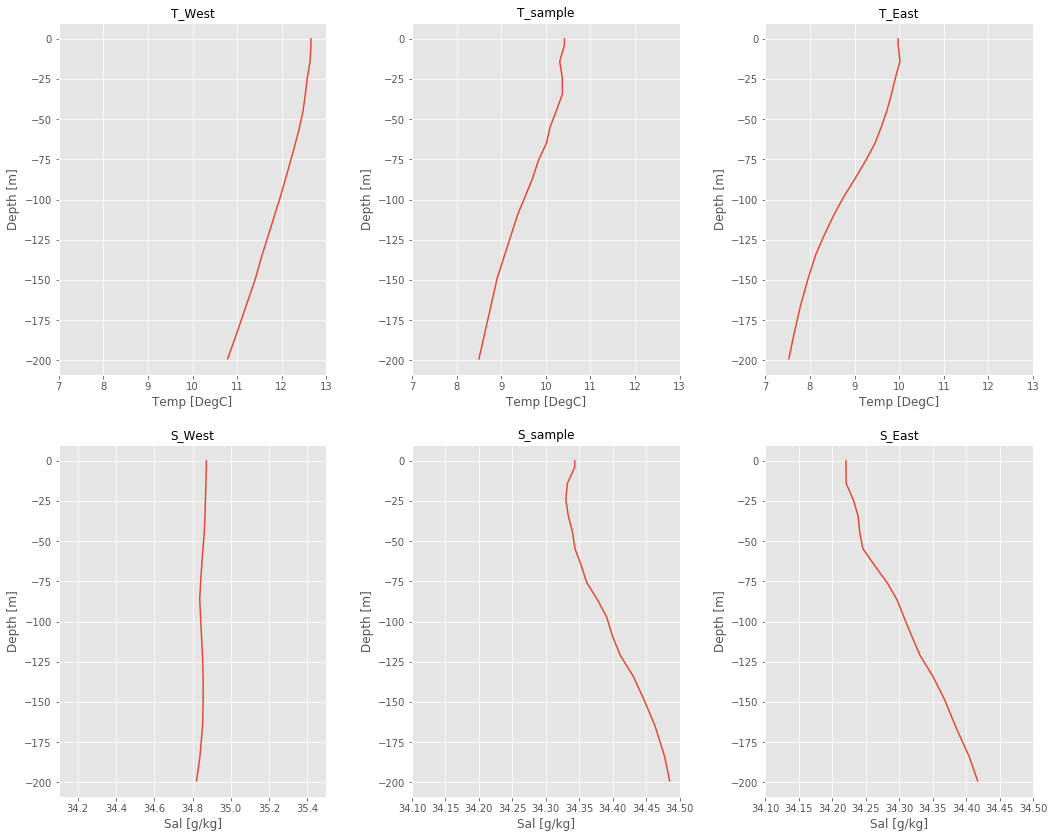

In [74]:
fig, ax = plt.subplots(figsize=(15, 12),nrows=2, ncols=3)

T_West = np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=0,arr=T[winter,0:200,16:20,0:20],func1d=np.nanmean),func1d=np.nanmean),func1d=np.nanmean)
plt.subplot(2, 3, 1)
plt.plot(T_West,-arange(0,200,1))
plt.xlim(7,13)
plt.xlabel('Temp [DegC]',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('T_West',fontsize=12)

S_West = np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=0,arr=S[winter,0:200,16:20,0:20],func1d=np.nanmean),func1d=np.nanmean),func1d=np.nanmean)
plt.subplot(2, 3, 4)
plt.plot(S_West,-arange(0,200,1))
plt.xlim(34.1,35.5)
plt.xlabel('Sal [g/kg]',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('S_West',fontsize=12)

T_sample = np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=0,arr=T[winter,0:200,16:20,24:30],func1d=np.nanmean),func1d=np.nanmean),func1d=np.nanmean)
plt.subplot(2, 3, 2)
plt.plot(T_sample,-arange(0,200,1))
plt.xlim(7,13)
plt.xlabel('Temp [DegC]',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('T_sample',fontsize=12)

S_sample = np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=0,arr=S[winter,0:200,16:20,24:30],func1d=np.nanmean),func1d=np.nanmean),func1d=np.nanmean)
plt.subplot(2, 3, 5)
plt.plot(S_sample,-arange(0,200,1))
plt.xlim(34.1,34.5)
plt.xlabel('Sal [g/kg]',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('S_sample',fontsize=12)

#plt.subplot(3, 2, 5)
#plt.plot(T_sample,S_sample)
#plt.title('TS_sample')

#plt.subplot(3, 2, 6)
#plt.plot(T_other,S_other)
#plt.title('TS_other')

T_East = np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=0,arr=T[winter,0:200,16:20,31:41],func1d=np.nanmean),func1d=np.nanmean),func1d=np.nanmean)
plt.subplot(2, 3, 3)
plt.plot(T_East,-arange(0,200,1))
plt.xlim(7,13)
plt.xlabel('Temp [DegC]',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('T_East',fontsize=12)

S_East = np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=1,arr=np.apply_along_axis(axis=0,arr=S[winter,0:200,16:20,31:41],func1d=np.nanmean),func1d=np.nanmean),func1d=np.nanmean)
plt.subplot(2, 3, 6)
plt.plot(S_East,-arange(0,200,1))
plt.xlim(34.1,34.5)
plt.xlabel('Sal [g/kg]',fontsize=12)
plt.ylabel('Depth [m]',fontsize=12)
plt.title('S_East',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/Outlier_sample.png',dpi=300)

In [ ]:
mean_T = np.apply_along_axis(axis=0,arr=T,func1d=np.nanmean)
mean_T = np.apply_along_axis(axis=0,arr=T,func1d=np.nanmean)

fig, ax = plt.subplots(figsize=(25, 20))#, ncols=2, nrows=3)

plt.subplot(3, 2, 1)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mean_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD mean',fontsize=12)

plt.subplot(3, 2, 2)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, median_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD median',fontsize=12)

plt.subplot(3, 2, 3)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, min_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD min',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/pmld_summary_stats.png',dpi=300)

## Calc seawater density using Salinity, Temperature and Pressure

### gswd using rho_t_exact

In [11]:
gswda = gsw.density.rho_t_exact(SA, T, P)-1000

In [12]:
gswpd = gsw.density.sigma0(SA, CT)

### Rho Alpha and Beta for Brunt Vaisala equation

In [326]:
gswd_ab = gsw.density.rho_alpha_beta(SA, CT, P)
gswd2a = gswd_ab[0]
a = gswd_ab[1].mean(axis=0).mean(axis=0).mean(axis=0)[0]
b = gswd_ab[2].mean(axis=0).mean(axis=0).mean(axis=0)[0]

In [328]:
print(a)
print(b)

0.00011552210516540154
0.0007630365866704359


In [341]:
#np.apply_along_axis(nanmin,0,np.apply_along_axis(nanmin, 0, (gswd2[0]-gswd1))).min()

In [13]:
#%% Sean function - one profile per time, lat, lon
# This works for mld_init 
def calc_rhomld_grid(var):

    """Calculate the mixed layer depth from the density difference method

    Args:
      var: density data file

    Return:
        MLD for each profile based on temperature difference

    Dependencies:
        numpy

    """
    import numpy as np
    den_lim=0.01
    ref_dpt=10

    mld_gswda = []

    try:
        ref_dpt_ind = np.nanargmin(np.abs(depth - ref_dpt))
        v = var[ref_dpt_ind:]
        diff_ind = np.where(abs(diff(v))>den_lim)[0][0] + ref_dpt_ind
        mld_gswda += depth[diff_ind],

    except:
        mld_gswda += np.nan,

    return mld_gswda

In [14]:
#np.apply_along_axis(diff,1,gswda)
mld_gswda = np.apply_along_axis(calc_rhomld_grid, 1, gswda)
#mld_gswda = np.squeeze(mld_gswda,axis=1)
mld_gswda = mld_gswda.clip(0,1000).astype(float)
mld_gswda[mld_gswda==0] = np.nan
mld_gswda = mld_gswda.squeeze(axis=1)

In [15]:
# Max mld based on density changes
np.apply_along_axis(nanmax,1,np.apply_along_axis(nanmax, 1, mld_gswda)).max()

185.0

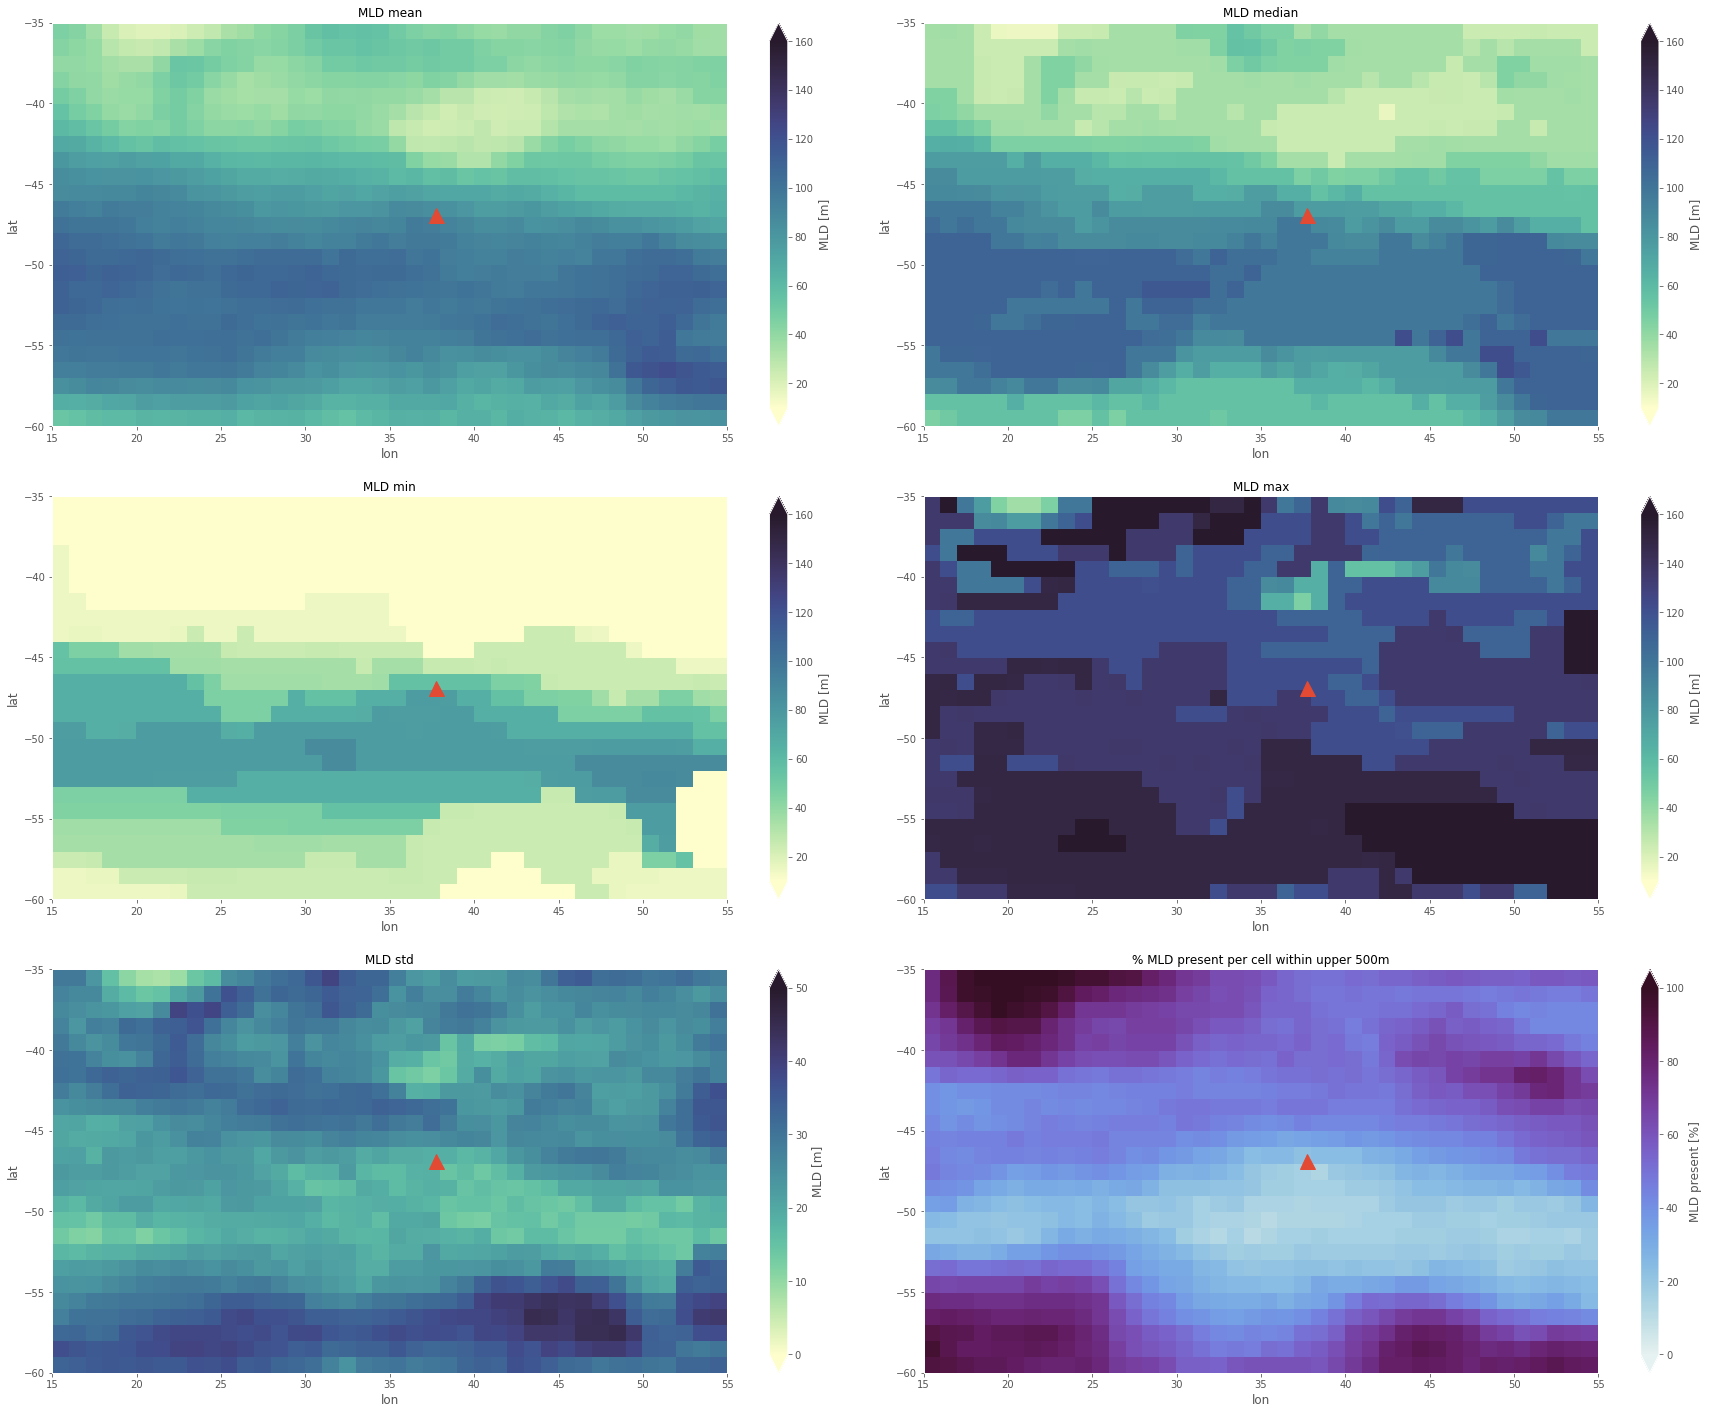

In [393]:
mean_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanmean)
median_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanmedian)
min_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanmin)
max_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanmax)
std_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanstd)
mld_present = 100-np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.isnan).sum(0)/84*100

fig, ax = plt.subplots(figsize=(25, 20))#, ncols=2, nrows=3)

plt.subplot(3, 2, 1)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mean_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD mean',fontsize=12)

plt.subplot(3, 2, 2)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, median_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD median',fontsize=12)

plt.subplot(3, 2, 3)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, min_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD min',fontsize=12)

plt.subplot(3, 2, 4)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, max_mld, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD max',fontsize=12)

plt.subplot(3, 2, 5)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, std_mld, cmap = cmo.deep, vmin=0, vmax=50)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('MLD std',fontsize=12)

plt.subplot(3, 2, 6)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_present, cmap = cmo.dense,vmin=0,vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('% MLD present per cell within upper 500m',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/pmld_summary_stats.png',dpi=300)

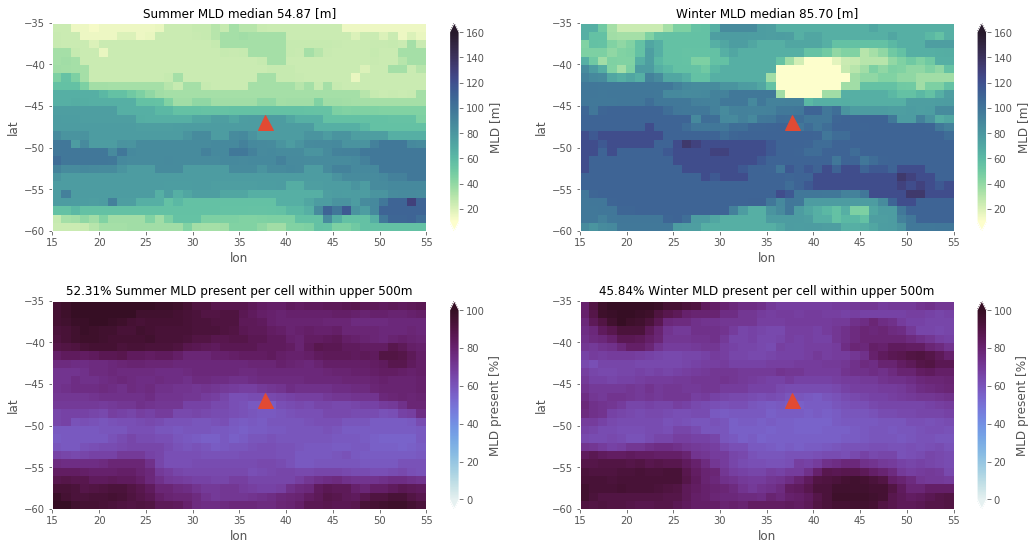

In [294]:
summer = [0, 1, 2, 9, 10, 11, 12, 13, 14,21, 22, 23, 24, 25, 26,33, 34, 35, 36, 37, 38,45, 46, 47, 48, 49, 50,57, 58, 59, 60, 61, 62,69, 70, 71, 72, 73, 74,81, 82, 83]
winter = [3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32,39,40,41,42,43,44,51,52,53,54,55,56,63,64,65,66,67,68,75,76,77,78,79,80]
mean_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanmean)
mld_gswda_summer = np.apply_along_axis(axis=0,arr=mld_gswda[summer],func1d=np.nanmedian)
mld_gswda_winter = np.apply_along_axis(axis=0,arr=mld_gswda[winter],func1d=np.nanmedian)
mld_present_summer = 100-np.apply_along_axis(axis=0,arr=mld_gswda[summer],func1d=np.isnan).sum(0)/84*100
mld_present_winter = 100-np.apply_along_axis(axis=0,arr=mld_gswda[winter],func1d=np.isnan).sum(0)/84*100
prop_mld_summer = 100-np.apply_along_axis(axis=0,arr=mld_gswda[summer],func1d=np.isnan).sum()/size(mld_gswda[summer])*100
prop_mld_winter = 100-np.apply_along_axis(axis=0,arr=mld_gswda[winter],func1d=np.isnan).sum()/size(mld_gswda[winter])*100

fig, ax = plt.subplots(figsize=(15, 8))#, ncols=2, nrows=3)

#plt.subplot(2, 3, 1)
#f1 = plt.figure(figsize=(10,5))
#plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mean_mld, vmin=10, vmax=120)
#plt.colorbar(extend='both').set_label('MLD [m]')
#plt.ylabel('lat')
#plt.xlabel('lon')
#plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
#plt.title('MLD mean (2009-2015) '+"{:.2f}".format(np.nanmean(mean_mld))+' [m]',fontsize=12)

plt.subplot(2, 2, 1)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_gswda_summer, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer MLD median '+"{:.2f}".format(np.nanmean(mld_gswda_summer))+' [m]',fontsize=12)

plt.subplot(2, 2, 2)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_gswda_winter, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter MLD median '+"{:.2f}".format(np.nanmean(mld_gswda_winter))+' [m]',fontsize=12)

plt.subplot(2, 2, 3)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_present_summer, cmap = cmo.dense, vmin=0, vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title("{:.2f}".format(prop_mld_summer) + '% Summer MLD present per cell within upper 500m',fontsize=12)

plt.subplot(2, 2, 4)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_present_winter, cmap = cmo.dense, vmin=0, vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title("{:.2f}".format(prop_mld_winter) + '% Winter MLD present per cell within upper 500m',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/pMLD.png',dpi=300)


# MLD based on Temp (Threshold)
Not used as medians are not similar to those in density calculations

In [295]:
#%% Sean function - one profile per time, lat, lon
# This works for Tmld_init 
def calc_Tmld(var, T_diff_lim=0.25):

    """Calculate the mixed layer depth from the temperature difference method

    Args:
      var: temperature or density data file

    Return:
        MLD for each profile based on temperature difference

    Dependencies:
        numpy

    """
    import numpy as np
    mld=[]
    
    try:
        T_diff = np.abs(var - var[0])
        dpt_diff = np.abs(diff(dpt))
        T_diff = np.delete(T_diff,[0])
        rho_diff = T_diff/dpt_diff
        x = rho_diff - T_diff_lim
        if len(x)>1:
            mld_ind = np.squeeze(np.where(x > 0))[0] #Remove single-dimensional entries from the shape of an array.
            mld = dpt[mld_ind]
        else:
            mld_ind = np.squeeze(np.where(x > 0))
            mld = dpt[mld_ind]
    except:
        mld = np.NaN
        #print('MLD not calculated: profile ' + str(i) + '. Setting to NaN')
    return mld


In [296]:
var = T[:,0:200,:,:]
dpt = var.depth.values
Tmld_df = np.apply_along_axis(calc_Tmld, 1, var)

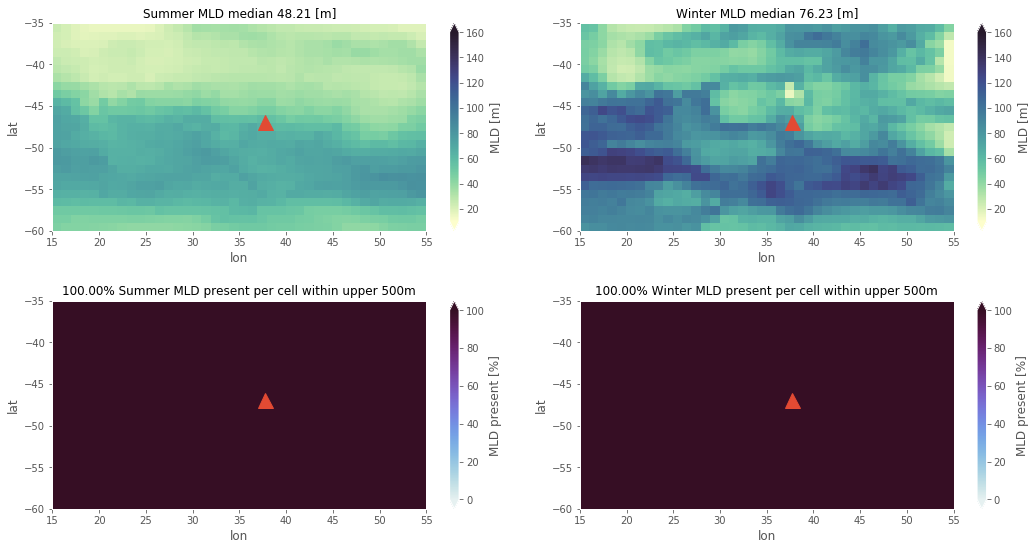

In [297]:
summer = [0, 1, 2, 9, 10, 11, 12, 13, 14,21, 22, 23, 24, 25, 26,33, 34, 35, 36, 37, 38,45, 46, 47, 48, 49, 50,57, 58, 59, 60, 61, 62,69, 70, 71, 72, 73, 74,81, 82, 83]
winter = [3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32,39,40,41,42,43,44,51,52,53,54,55,56,63,64,65,66,67,68,75,76,77,78,79,80]
mean_Tmld = np.apply_along_axis(axis=0,arr=Tmld_df,func1d=np.nanmean)
Tmld_gswda_summer = np.apply_along_axis(axis=0,arr=Tmld_df[summer],func1d=np.nanmedian)
Tmld_gswda_winter = np.apply_along_axis(axis=0,arr=Tmld_df[winter],func1d=np.nanmedian)
Tmld_present_summer = 100-np.apply_along_axis(axis=0,arr=Tmld_df[summer],func1d=np.isnan).sum(0)/84*100
Tmld_present_winter = 100-np.apply_along_axis(axis=0,arr=Tmld_df[winter],func1d=np.isnan).sum(0)/84*100
prop_Tmld_summer = 100-np.apply_along_axis(axis=0,arr=Tmld_df[summer],func1d=np.isnan).sum()/size(Tmld_df[summer])*100
prop_Tmld_winter = 100-np.apply_along_axis(axis=0,arr=Tmld_df[winter],func1d=np.isnan).sum()/size(Tmld_df[winter])*100

fig, ax = plt.subplots(figsize=(15, 8))#, ncols=2, nrows=3)

#plt.subplot(2, 3, 1)
#f1 = plt.figure(figsize=(10,5))
#plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mean_mld, vmin=10, vmax=120)
#plt.colorbar(extend='both').set_label('MLD [m]')
#plt.ylabel('lat')
#plt.xlabel('lon')
#plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
#plt.title('MLD mean (2009-2015) '+"{:.2f}".format(np.nanmean(mean_mld))+' [m]',fontsize=12)

plt.subplot(2, 2, 1)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_gswda_summer, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer MLD median '+"{:.2f}".format(np.nanmean(Tmld_gswda_summer))+' [m]',fontsize=12)

plt.subplot(2, 2, 2)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_gswda_winter, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter MLD median '+"{:.2f}".format(np.nanmean(Tmld_gswda_winter))+' [m]',fontsize=12)

plt.subplot(2, 2, 3)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_present_summer, cmap = cmo.dense, vmin=0, vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title("{:.2f}".format(prop_Tmld_summer) + '% Summer MLD present per cell within upper 500m',fontsize=12)

plt.subplot(2, 2, 4)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_present_winter, cmap = cmo.dense, vmin=0, vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title("{:.2f}".format(prop_Tmld_winter) + '% Winter MLD present per cell within upper 500m',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/pTMLD_unused.png',dpi=300)


# MLD based on Temp (Hybrid - gradient & threshold)
Used in further analysis

In [298]:
#%% Sean function

def calc_Temp_mld(var, TDiff_lim=0.1, deltaT_lim=0.25, ref_dpt=10): # This is greater than!!

    """" Therm_dep - Calculate the mixed layer depth from the rate of Temp change method (Where first differential > TDiff_lim [DegC/m])
         Tmld - Calculate the mixed layer depth from absolute diff method (Where T @ surface - T @ depth > 2 [DegC])
    Args:
      var: temperature data file
      dpt: depth data

    Return:
        time series of the mixed layer depth

    Dependencies:
        numpy

    """
    import numpy as np
    Tmld = []
    Therm_dep = []
    
    try:
        ref_dpt_ind = np.nanargmin(np.abs(dpt - ref_dpt)) # gets the index for the min value for depth ignoring Nan values.
        v = var[ref_dpt_ind:]
        d = dpt[ref_dpt_ind:]
        Tdiff_ind = np.where(diff(v)<-TDiff_lim)[0][0]
        Therm_depi = d[Tdiff_ind] 
        Therm_dep += Therm_depi,

    except:
        Therm_dep += np.NaN,
        
    try:
        ref_dpt_ind = np.nanargmin(np.abs(dpt - ref_dpt)) # gets the index for the min value for depth ignoring Nan values.
        rho_diff = np.abs(var[ref_dpt_ind:] - var[ref_dpt_ind])
        x = rho_diff - deltaT_lim
        x = np.squeeze(np.where(x > 0))[0]
        Tmld_ind = x + ref_dpt_ind
        Tmld += d[Tmld_ind],            

    except:
        Tmld += np.NaN,
        #print('MLD not calculated: profile ' + str(n[dive]) + '. Setting to NaN')

    return pd.DataFrame({'Therm_dep':Therm_dep,'Tmld':Tmld})

In [299]:
var = T[:,0:200,:,:]
dpt = var.depth.values
Thermocline_depth = np.apply_along_axis(calc_Temp_mld, 1, var).squeeze()

In [300]:
Therm_dep = Thermocline_depth[:,0,:,:]
Tmld = Thermocline_depth[:,1,:,:]

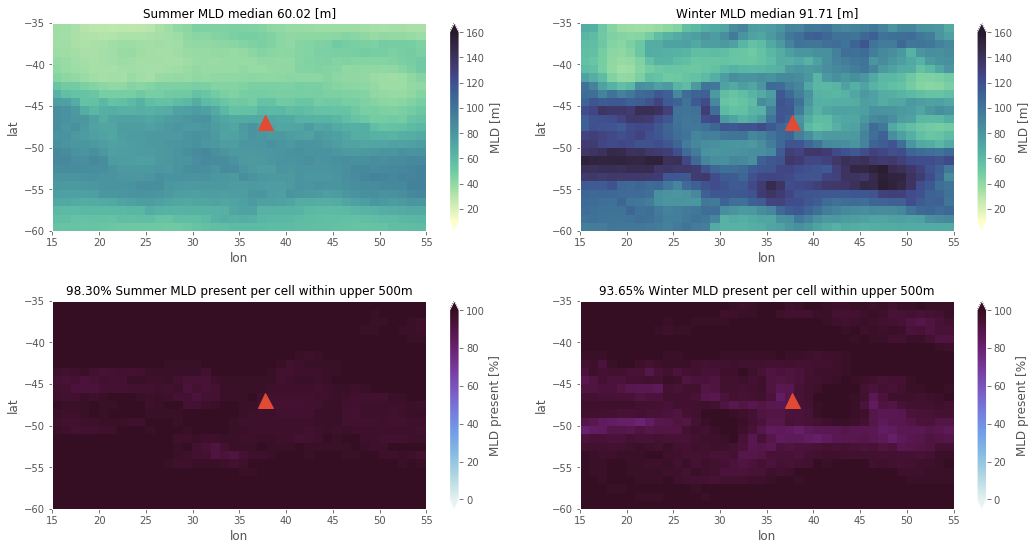

In [301]:
summer = [0, 1, 2, 9, 10, 11, 12, 13, 14,21, 22, 23, 24, 25, 26,33, 34, 35, 36, 37, 38,45, 46, 47, 48, 49, 50,57, 58, 59, 60, 61, 62,69, 70, 71, 72, 73, 74,81, 82, 83]
winter = [3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32,39,40,41,42,43,44,51,52,53,54,55,56,63,64,65,66,67,68,75,76,77,78,79,80]
mean_Tmld = np.apply_along_axis(axis=0,arr=Tmld_df,func1d=np.nanmean)
Tmld_gswda_summer = np.apply_along_axis(axis=0,arr=Tmld[summer],func1d=np.nanmedian)
Tmld_gswda_winter = np.apply_along_axis(axis=0,arr=Tmld[winter],func1d=np.nanmedian)
Tmld_present_summer = 100-np.apply_along_axis(axis=0,arr=Tmld[summer],func1d=np.isnan).sum(0)/84*100
Tmld_present_winter = 100-np.apply_along_axis(axis=0,arr=Tmld[winter],func1d=np.isnan).sum(0)/84*100
prop_Tmld_summer = 100-np.apply_along_axis(axis=0,arr=Tmld[summer],func1d=np.isnan).sum()/size(Tmld[summer])*100
prop_Tmld_winter = 100-np.apply_along_axis(axis=0,arr=Tmld[winter],func1d=np.isnan).sum()/size(Tmld[winter])*100

fig, ax = plt.subplots(figsize=(15, 8))#, ncols=2, nrows=3)

#plt.subplot(2, 3, 1)
#f1 = plt.figure(figsize=(10,5))
#plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mean_mld, vmin=10, vmax=120)
#plt.colorbar(extend='both').set_label('MLD [m]')
#plt.ylabel('lat')
#plt.xlabel('lon')
#plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
#plt.title('MLD mean (2009-2015) '+"{:.2f}".format(np.nanmean(mean_mld))+' [m]',fontsize=12)

plt.subplot(2, 2, 1)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_gswda_summer, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer MLD median '+"{:.2f}".format(np.nanmean(Tmld_gswda_summer))+' [m]',fontsize=12)

plt.subplot(2, 2, 2)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_gswda_winter, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter MLD median '+"{:.2f}".format(np.nanmean(Tmld_gswda_winter))+' [m]',fontsize=12)

plt.subplot(2, 2, 3)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_present_summer, cmap = cmo.dense, vmin=0, vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title("{:.2f}".format(prop_Tmld_summer) + '% Summer MLD present per cell within upper 500m',fontsize=12)

plt.subplot(2, 2, 4)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_present_winter, cmap = cmo.dense, vmin=0, vmax=100)
plt.colorbar(extend='both').set_label('MLD present [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title("{:.2f}".format(prop_Tmld_winter) + '% Winter MLD present per cell within upper 500m',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/pTMLD.png',dpi=300)


# Plot Tmld and mld

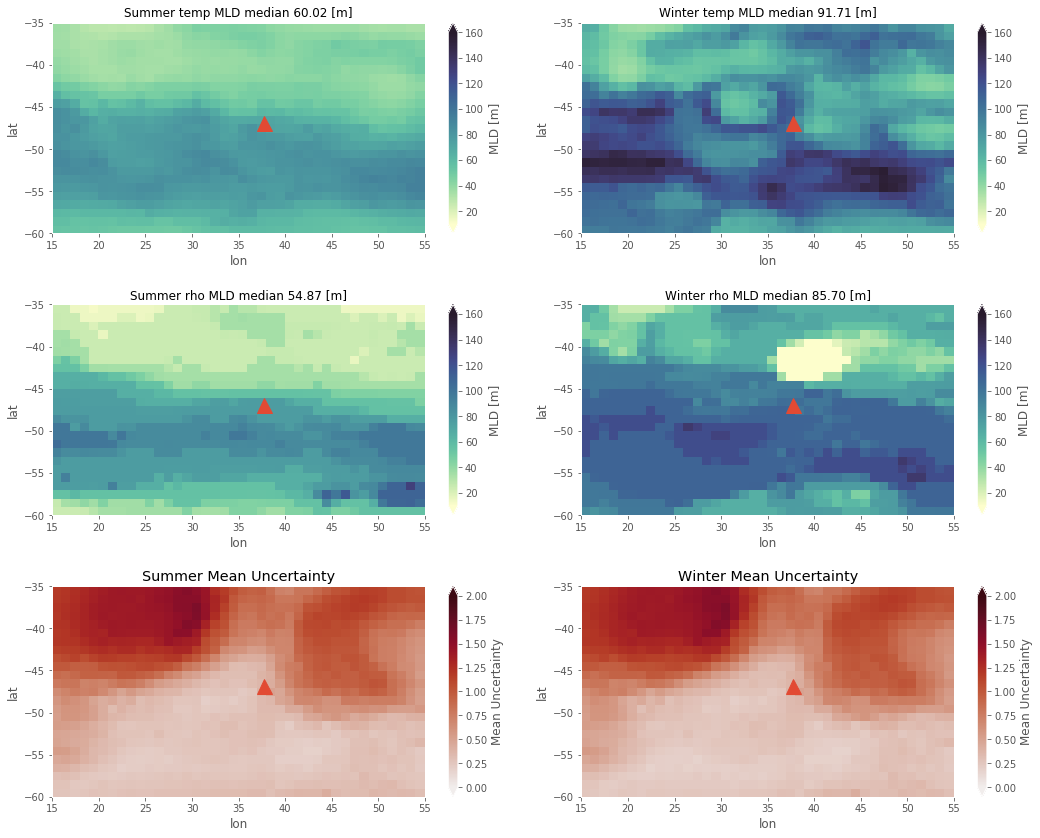

In [302]:
summer = [0, 1, 2, 9, 10, 11, 12, 13, 14,21, 22, 23, 24, 25, 26,33, 34, 35, 36, 37, 38,45, 46, 47, 48, 49, 50,57, 58, 59, 60, 61, 62,69, 70, 71, 72, 73, 74,81, 82, 83]
winter = [3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32,39,40,41,42,43,44,51,52,53,54,55,56,63,64,65,66,67,68,75,76,77,78,79,80]
mean_Tmld = np.apply_along_axis(axis=0,arr=Tmld_df,func1d=np.nanmean)
Tmld_gswda_summer = np.apply_along_axis(axis=0,arr=Tmld[summer],func1d=np.nanmedian)
Tmld_gswda_winter = np.apply_along_axis(axis=0,arr=Tmld[winter],func1d=np.nanmedian)
Tmld_present_summer = 100-np.apply_along_axis(axis=0,arr=Tmld[summer],func1d=np.isnan).sum(0)/84*100
Tmld_present_winter = 100-np.apply_along_axis(axis=0,arr=Tmld[winter],func1d=np.isnan).sum(0)/84*100
prop_Tmld_summer = 100-np.apply_along_axis(axis=0,arr=Tmld[summer],func1d=np.isnan).sum()/size(Tmld[summer])*100
prop_Tmld_winter = 100-np.apply_along_axis(axis=0,arr=Tmld[winter],func1d=np.isnan).sum()/size(Tmld[winter])*100

mean_mld = np.apply_along_axis(axis=0,arr=mld_gswda,func1d=np.nanmean)
mld_gswda_summer = np.apply_along_axis(axis=0,arr=mld_gswda[summer],func1d=np.nanmedian)
mld_gswda_winter = np.apply_along_axis(axis=0,arr=mld_gswda[winter],func1d=np.nanmedian)
mld_present_summer = 100-np.apply_along_axis(axis=0,arr=mld_gswda[summer],func1d=np.isnan).sum(0)/84*100
mld_present_winter = 100-np.apply_along_axis(axis=0,arr=mld_gswda[winter],func1d=np.isnan).sum(0)/84*100
prop_mld_summer = 100-np.apply_along_axis(axis=0,arr=mld_gswda[summer],func1d=np.isnan).sum()/size(mld_gswda[summer])*100
prop_mld_winter = 100-np.apply_along_axis(axis=0,arr=mld_gswda[winter],func1d=np.isnan).sum()/size(mld_gswda[winter])*100

u_winter = u[winter][:,0:17,:,:]
u_summer = u[summer][:,0:17,:,:]
lonn = Tmld_init.lon.values
latt = Tmld_init.lat.values
umedian_summer = np.apply_along_axis(axis=0,arr=u_summer,func1d=np.nanmean)
umedian_winter = np.apply_along_axis(axis=0,arr=u_winter,func1d=np.nanmean)
umedian_summer = np.apply_along_axis(axis=0,arr=umedian_summer,func1d=np.nanmean)
umedian_winter = np.apply_along_axis(axis=0,arr=umedian_winter,func1d=np.nanmean)

fig, ax = plt.subplots(figsize=(15, 12))#, ncols=2, nrows=3)

#plt.subplot(2, 3, 1)
#f1 = plt.figure(figsize=(10,5))
#plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mean_mld, vmin=10, vmax=120)
#plt.colorbar(extend='both').set_label('MLD [m]')
#plt.ylabel('lat')
#plt.xlabel('lon')
#plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
#plt.title('MLD mean (2009-2015) '+"{:.2f}".format(np.nanmean(mean_mld))+' [m]',fontsize=12)

plt.subplot(3, 2, 1)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_gswda_summer, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer temp MLD median '+"{:.2f}".format(np.nanmean(Tmld_gswda_summer))+' [m]',fontsize=12)

plt.subplot(3, 2, 2)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Tmld_gswda_winter, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter temp MLD median '+"{:.2f}".format(np.nanmean(Tmld_gswda_winter))+' [m]',fontsize=12)

plt.subplot(3, 2, 3)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_gswda_summer, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer rho MLD median '+"{:.2f}".format(np.nanmean(mld_gswda_summer))+' [m]',fontsize=12)

plt.subplot(3, 2, 4)
#f1 = plt.figure(figsize=(10,5))
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, mld_gswda_winter, cmap = cmo.deep, vmin=10, vmax=160)
plt.colorbar(extend='both').set_label('MLD [m]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter rho MLD median '+"{:.2f}".format(np.nanmean(mld_gswda_winter))+' [m]',fontsize=12)

plt.subplot(3, 2, 5)
plt.pcolormesh(lonn, latt, umedian_summer, cmap = cmo.amp, vmin=0, vmax=2)
plt.colorbar(extend='both').set_label('Mean Uncertainty')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer Mean Uncertainty')
          
plt.subplot(3, 2, 6)
plt.pcolormesh(lonn, latt, umedian_winter, cmap = cmo.amp, vmin=0, vmax=2)
plt.colorbar(extend='both').set_label('Mean Uncertainty')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter Mean Uncertainty')
          
fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/mld_methods.png',dpi=300)


In [ ]:
### the minimum depth of first >0.01 density is 10m

In [321]:
print(Tmld_init.lat.values)
print(Tmld_init.lon.values)
mld_gswda[winter,19,26]

[-60. -59. -58. -57. -56. -55. -54. -53. -52. -51. -50. -49. -48. -47.
 -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36. -35.]
[15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.
 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.
 51. 52. 53. 54. 55.]


array([ 10.,  10.,  nan,  nan,  nan,  nan,  10.,  10.,  nan,  nan,  nan,
        nan,  10.,  10.,  nan,  nan,  nan,  nan,  35.,  10.,  nan,  nan,
        nan,  nan,  10.,  10.,  nan,  nan,  nan,  nan,  10.,  10., 122.,
        nan,  nan,  nan,  10.,  10.,  nan,  nan,  nan,  nan])

# Vertical stability!

# Calculating N_sq using addition of NT and Ns

## Calculating Nt

In [28]:
#%% Nt

#%% Sean function - one profile per time, lat, lon
# This works for Tmld_init 
def calc_Nt(var):

    """Calculate the mixed layer depth from the temperature difference method

    Args:
      var: temperature or density data file

    Return:
        MLD for each profile based on temperature difference

    Dependencies:
        numpy

    """
    import numpy as np
    Nt=[]

    try:
        T_diff = diff(var)/diff(dpt)
        nt = T_diff*(g*alpha)
        Nt += nt,
    except:
        Nt += np.NaN

    return Nt

In [29]:
g = 9.8
alpha = -0.0001155   
dpt = depth[:200]
Nt = np.apply_along_axis(calc_Nt, 1, PT[:,:200,:,:])
Nt = np.squeeze(Nt)

In [30]:
Summer_mean_Nt = np.apply_along_axis(axis=0,arr=Nt[summer,:,:,:],func1d=np.nanmean)
Winter_mean_Nt = np.apply_along_axis(axis=0,arr=Nt[winter,:,:,:],func1d=np.nanmean)
Year_mean_Nt = np.apply_along_axis(axis=0,arr=Nt,func1d=np.nanmean)

### Plotting Nt

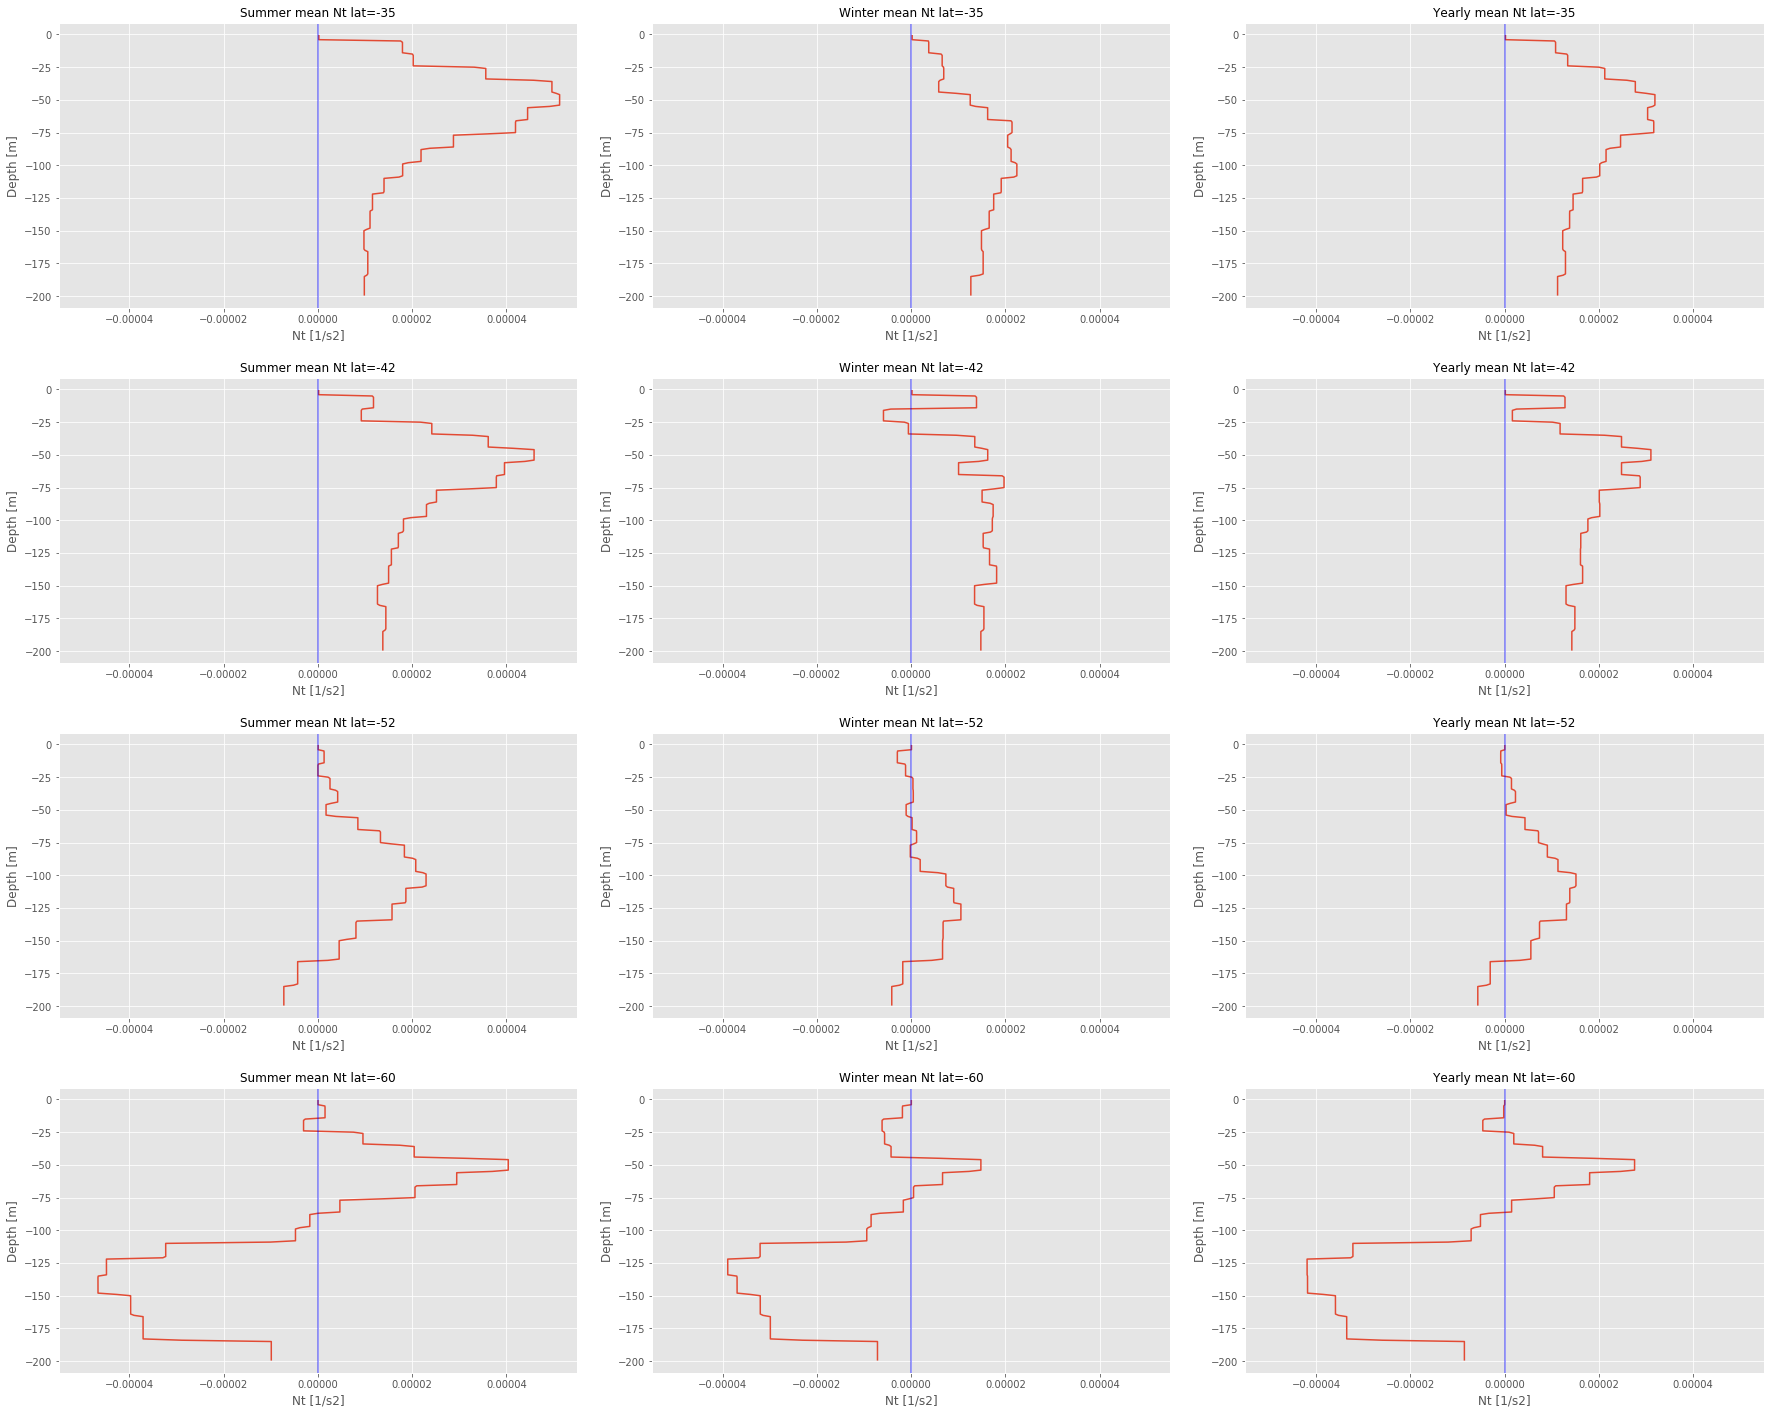

In [332]:
fig, ax = plt.subplots(figsize=(25, 20), ncols=3, nrows=4)

#%% Nt

plt.subplot(4, 3, 1)
plt.plot(Summer_mean_Nt[:,25,26],-depth[:199]) # -35 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Summer mean Nt lat=-35',fontsize=12)

plt.subplot(4, 3, 2)
plt.plot(Winter_mean_Nt[:,25,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Winter mean Nt lat=-35',fontsize=12)

plt.subplot(4, 3, 3)
plt.plot(Year_mean_Nt[:,25,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Yearly mean Nt lat=-35',fontsize=12)

plt.subplot(4, 3, 4)
plt.plot(Summer_mean_Nt[:,19,26],-depth[:199])  # -42 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Summer mean Nt lat=-42',fontsize=12)

plt.subplot(4, 3, 5)
plt.plot(Winter_mean_Nt[:,19,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Winter mean Nt lat=-42',fontsize=12)

plt.subplot(4, 3, 6)
plt.plot(Year_mean_Nt[:,19,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Yearly mean Nt lat=-42',fontsize=12)

plt.subplot(4, 3, 7)
plt.plot(Summer_mean_Nt[:,8,26],-depth[:199]) # -52 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Summer mean Nt lat=-52',fontsize=12)

plt.subplot(4, 3, 8)
plt.plot(Winter_mean_Nt[:,8,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Winter mean Nt lat=-52',fontsize=12)

plt.subplot(4, 3, 9)
plt.plot(Year_mean_Nt[:,8,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Yearly mean Nt lat=-52',fontsize=12)

plt.subplot(4, 3, 10)
plt.plot(Summer_mean_Nt[:,0,26],-depth[:199]) # -60 lat, 40 lon
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Summer mean Nt lat=-60',fontsize=12)

plt.subplot(4, 3, 11)
plt.plot(Winter_mean_Nt[:,0,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Winter mean Nt lat=-60',fontsize=12)

plt.subplot(4, 3, 12)
plt.plot(Year_mean_Nt[:,0,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nt [1/s2]')
plt.title('Yearly mean Nt lat=-60',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/Nt_profile_eg.png',dpi=300)


## Calculating Ns

In [31]:
#%% Ns

#%% Sean function - one profile per time, lat, lon
# This works for Smld_init 
def calc_Ns(var):

    """Calculate the mixed layer depth from the temperature difference method

    Args:
      var: temperature or density data file

    Return:
        MLD for each profile based on temperature difference

    Dependencies:
        numpy

    """
    import numpy as np
    Ns=[]

    try:
        S_diff = diff(var)/diff(dpt)
        ns = S_diff*(-g*beta)
        Ns += ns,
    except:
        Ns += np.NaN

    return Ns

In [32]:
g = 9.8
beta = -0.000763
dpt = depth[:200]
Ns = np.apply_along_axis(calc_Ns, 1, SA[:,:200,:,:])
Ns = np.squeeze(Ns)

In [33]:
Summer_mean_Ns = np.apply_along_axis(axis=0,arr=Ns[summer,:,:,:],func1d=np.nanmean)
Winter_mean_Ns = np.apply_along_axis(axis=0,arr=Ns[winter,:,:,:],func1d=np.nanmean)
Year_mean_Ns = np.apply_along_axis(axis=0,arr=Ns,func1d=np.nanmean)

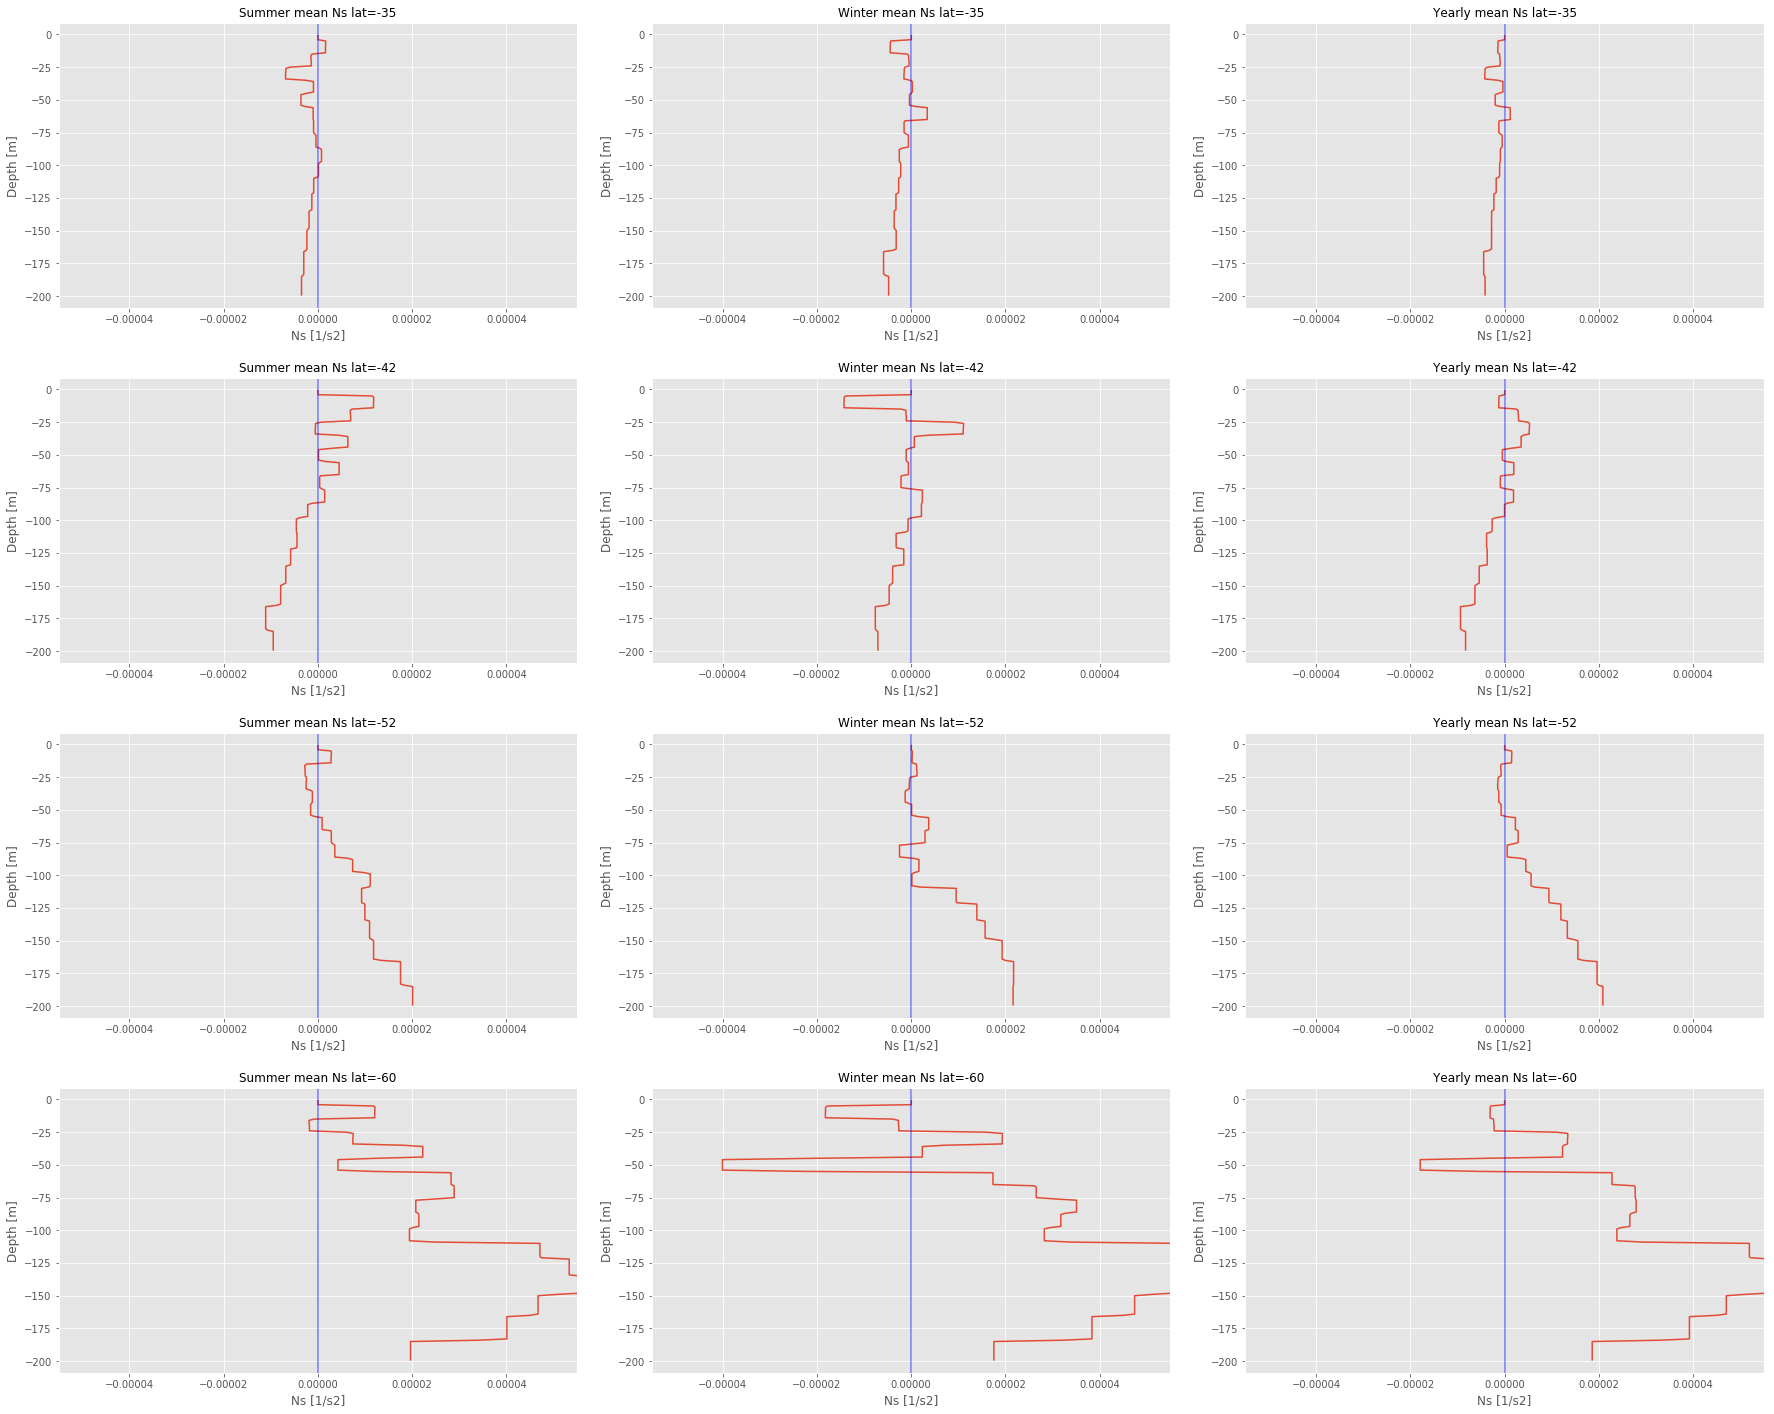

In [336]:
fig,ax = plt.subplots(figsize=(25, 20), ncols=4, nrows=3)

#%% Nt

plt.subplot(4, 3, 1)
plt.plot(Summer_mean_Ns[:,25,26],-depth[:199]) # -35 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Summer mean Ns lat=-35',fontsize=12)

plt.subplot(4, 3, 2)
plt.plot(Winter_mean_Ns[:,25,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Winter mean Ns lat=-35',fontsize=12)

plt.subplot(4, 3, 3)
plt.plot(Year_mean_Ns[:,25,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Yearly mean Ns lat=-35',fontsize=12)

plt.subplot(4, 3, 4)
plt.plot(Summer_mean_Ns[:,19,26],-depth[:199])  # -42 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Summer mean Ns lat=-42',fontsize=12)

plt.subplot(4, 3, 5)
plt.plot(Winter_mean_Ns[:,19,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Winter mean Ns lat=-42',fontsize=12)

plt.subplot(4, 3, 6)
plt.plot(Year_mean_Ns[:,19,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Yearly mean Ns lat=-42',fontsize=12)

plt.subplot(4, 3, 7)
plt.plot(Summer_mean_Ns[:,8,26],-depth[:199]) # -52 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Summer mean Ns lat=-52',fontsize=12)

plt.subplot(4, 3, 8)
plt.plot(Winter_mean_Ns[:,8,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Winter mean Ns lat=-52',fontsize=12)

plt.subplot(4, 3, 9)
plt.plot(Year_mean_Ns[:,8,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Yearly mean Ns lat=-52',fontsize=12)

plt.subplot(4, 3, 10)
plt.plot(Summer_mean_Ns[:,0,26],-depth[:199]) # -60 lat, 40 lon
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Summer mean Ns lat=-60',fontsize=12)

plt.subplot(4, 3, 11)
plt.plot(Winter_mean_Ns[:,0,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Winter mean Ns lat=-60',fontsize=12)

plt.subplot(4, 3, 12)
plt.plot(Year_mean_Ns[:,0,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Ns [1/s2]')
plt.title('Yearly mean Ns lat=-60',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/Ns_profile_eg.png',dpi=300)


# Nsq calculated using sum of Nt and Ns
Similar results when using other methods e.g. slide in google slides

In [35]:
Nsq=Nt+Ns
Nsq = np.squeeze(Nsq)
Summer_mean_Nsq = np.apply_along_axis(axis=0,arr=Nsq[summer,:,:,:],func1d=np.nanmean)
Winter_mean_Nsq = np.apply_along_axis(axis=0,arr=Nsq[winter,:,:,:],func1d=np.nanmean)
Year_mean_Nsq = np.apply_along_axis(axis=0,arr=Nsq,func1d=np.nanmean)

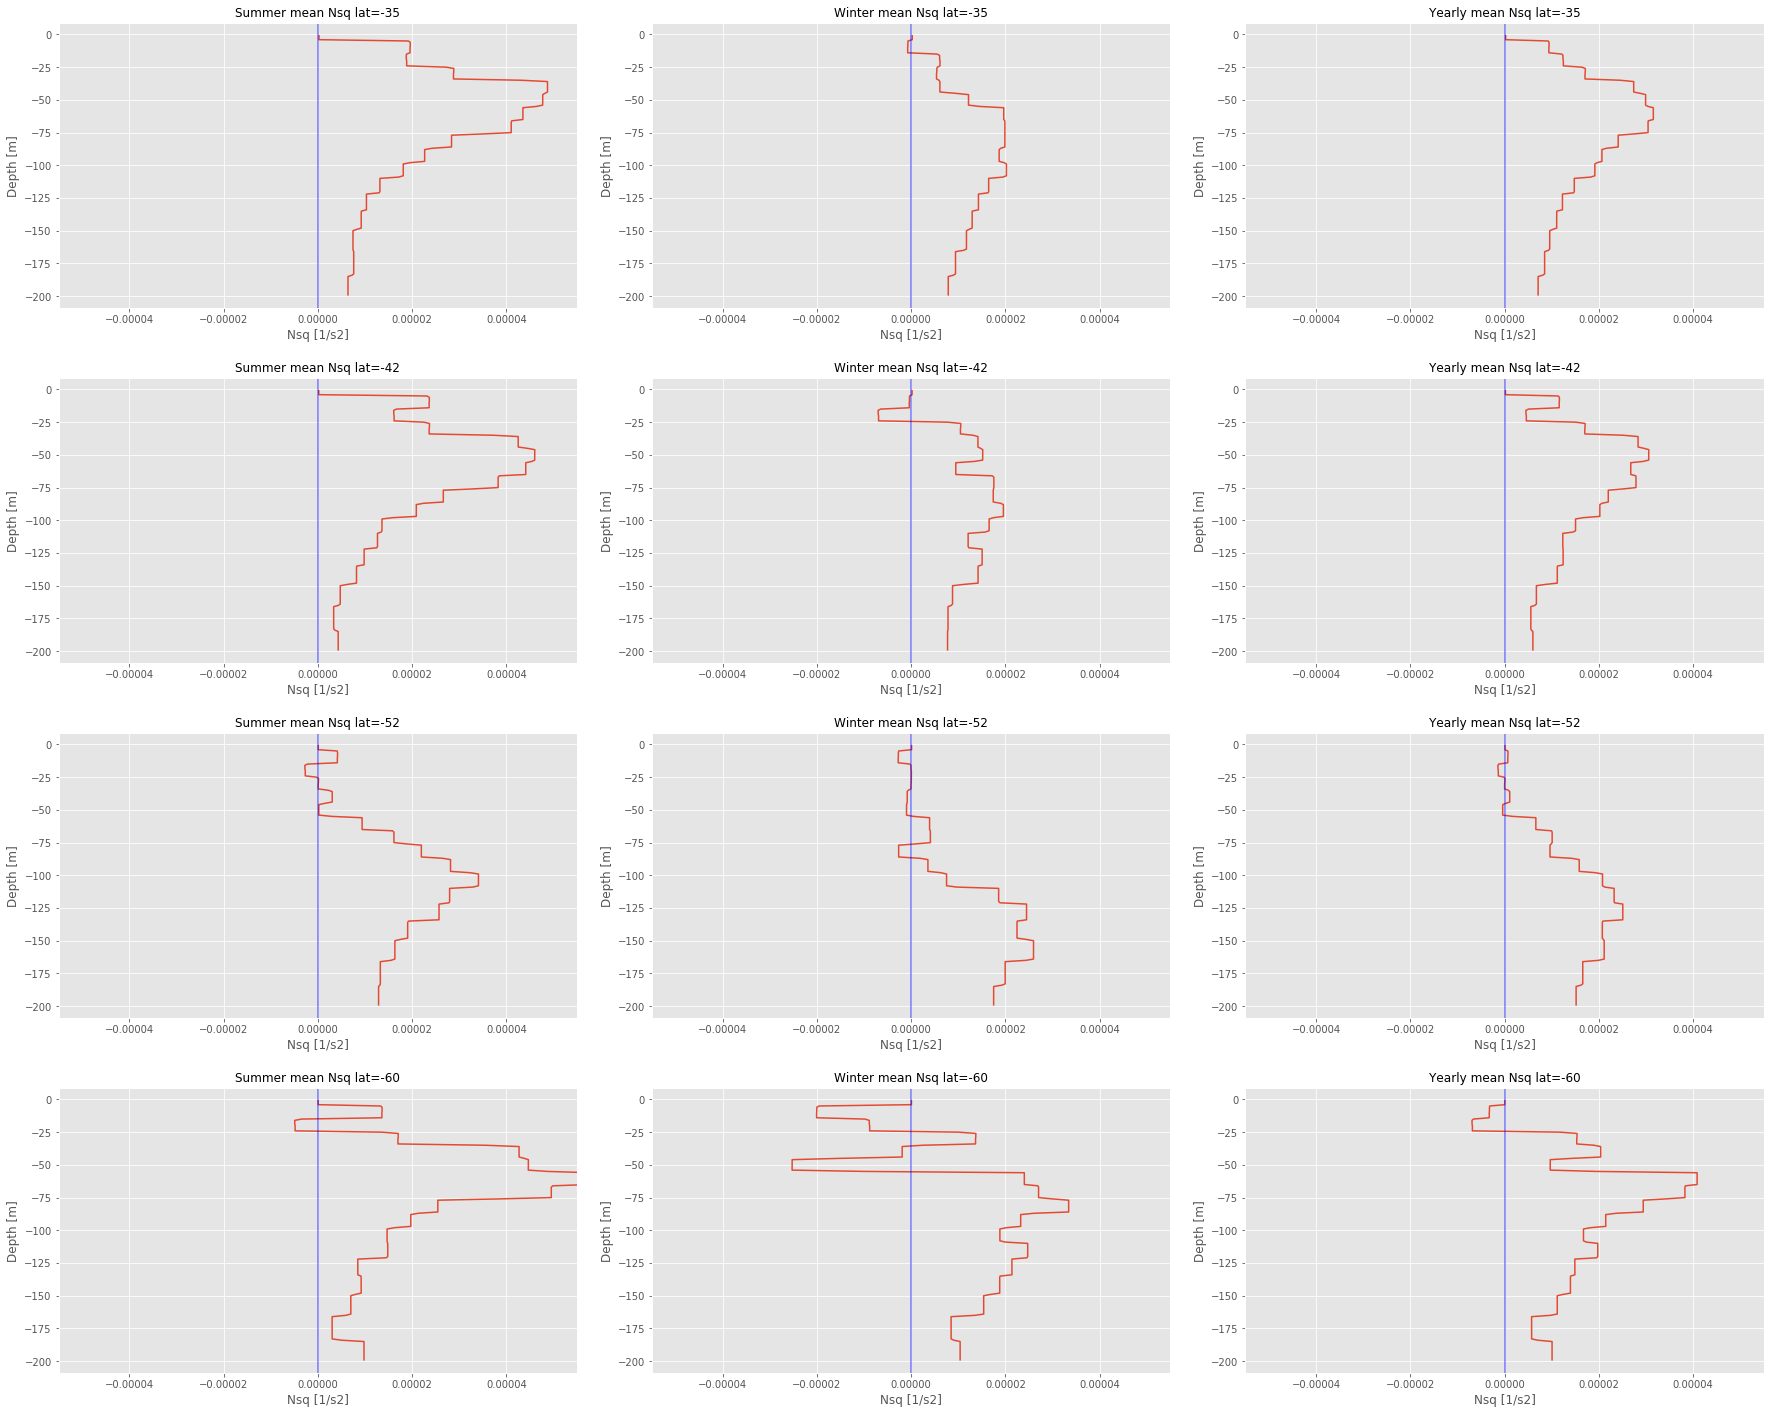

In [342]:
fig,ax = plt.subplots(figsize=(25, 20), ncols=4, nrows=3)

#%% Nsq

plt.subplot(4, 3, 1)
plt.plot(Summer_mean_Nsq[:,25,26],-depth[:199]) # -35 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Summer mean Nsq lat=-35',fontsize=12)

plt.subplot(4, 3, 2)
plt.plot(Winter_mean_Nsq[:,25,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Winter mean Nsq lat=-35',fontsize=12)

plt.subplot(4, 3, 3)
plt.plot(Year_mean_Nsq[:,25,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Yearly mean Nsq lat=-35',fontsize=12)

plt.subplot(4, 3, 4)
plt.plot(Summer_mean_Nsq[:,19,26],-depth[:199])  # -42 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Summer mean Nsq lat=-42',fontsize=12)

plt.subplot(4, 3, 5)
plt.plot(Winter_mean_Nsq[:,19,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Winter mean Nsq lat=-42',fontsize=12)

plt.subplot(4, 3, 6)
plt.plot(Year_mean_Nsq[:,19,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Yearly mean Nsq lat=-42',fontsize=12)

plt.subplot(4, 3, 7)
plt.plot(Summer_mean_Nsq[:,8,26],-depth[:199]) # -52 lat
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Summer mean Nsq lat=-52',fontsize=12)

plt.subplot(4, 3, 8)
plt.plot(Winter_mean_Nsq[:,8,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Winter mean Nsq lat=-52',fontsize=12)

plt.subplot(4, 3, 9)
plt.plot(Year_mean_Nsq[:,8,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Yearly mean Nsq lat=-52',fontsize=12)

plt.subplot(4, 3, 10)
plt.plot(Summer_mean_Nsq[:,0,26],-depth[:199]) # -60 lat, 40 lon
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Summer mean Nsq lat=-60',fontsize=12)

plt.subplot(4, 3, 11)
plt.plot(Winter_mean_Nsq[:,0,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Winter mean Nsq lat=-60',fontsize=12)

plt.subplot(4, 3, 12)
plt.plot(Year_mean_Nsq[:,0,26],-depth[:199])
plt.axvline(0,c='b',alpha=0.5)
plt.xlim(-0.000055,0.000055)
plt.ylabel('Depth [m]')
plt.xlabel('Nsq [1/s2]')
plt.title('Yearly mean Nsq lat=-60',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/Nsq_profile_eg.png',dpi=300)


## Calculating Nsq at base of the mixed layer

In [45]:
ntime, nlat, nlon = mld_gswda.shape
mld_base_Nsq = np.empty((ntime, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            try:
                mld_base_Nsq[time, lat, lon] = np.nanmean(Nsq[time,np.int(mld_gswda[time, lat, lon]):np.int(mld_gswda[time, lat, lon])+15,lat,lon])
            except:
                mld_base_Nsq[time, lat, lon] = np.NaN

## Calculating Nt & Ns at base of the mixed layer

In [47]:
ntime, nlat, nlon = mld_gswda.shape
mld_base_Nt = np.empty((ntime, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            try:
                mld_base_Nt[time, lat, lon] = np.nanmean(Nt[time,np.int(mld_gswda[time, lat, lon]):np.int(mld_gswda[time, lat, lon])+15,lat,lon])
            except:
                mld_base_Nt[time, lat, lon] = np.NaN

mld_base_Ns = np.empty((ntime, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            try:
                mld_base_Ns[time, lat, lon] = np.nanmean(Ns[time,np.int(mld_gswda[time, lat, lon]):np.int(mld_gswda[time, lat, lon])+15,lat,lon])
            except:
                mld_base_Ns[time, lat, lon] = np.NaN

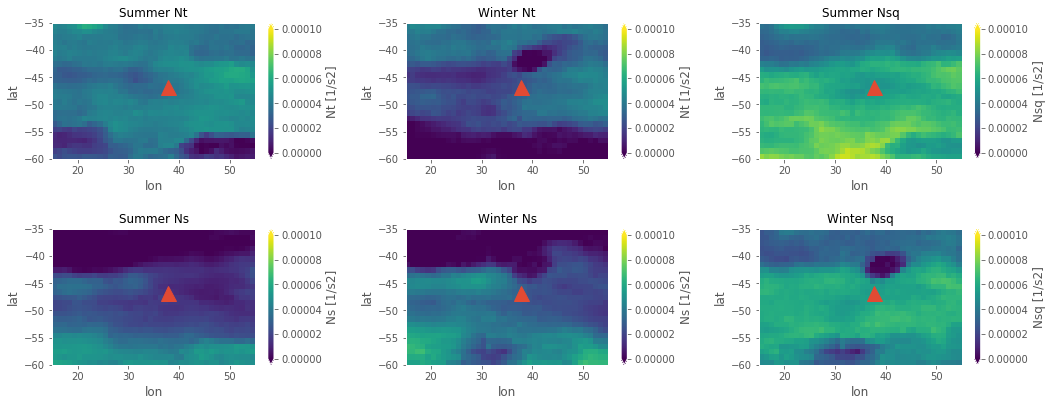

In [51]:
fig,ax = plt.subplots(figsize=(15, 6), ncols=3, nrows=2)

Summer_mld_base_Nt = np.apply_along_axis(axis=0,arr=mld_base_Nt[summer],func1d=np.nanmean)

plt.subplot(2, 3, 1)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Summer_mld_base_Nt, vmin=0, vmax=0.00010)
plt.colorbar(extend='both').set_label('Nt [1/s2]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer Nt',fontsize=12)

Winter_mld_base_Nt = np.apply_along_axis(axis=0,arr=mld_base_Nt[winter],func1d=np.nanmean)

plt.subplot(2, 3, 2)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Winter_mld_base_Nt, vmin=0, vmax=0.00010)
plt.colorbar(extend='both').set_label('Nt [1/s2]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter Nt',fontsize=12)

Summer_mld_base_Nsq = np.apply_along_axis(axis=0,arr=mld_base_Nsq[summer],func1d=np.nanmean)

plt.subplot(2, 3, 3)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Summer_mld_base_Nsq, vmin=0, vmax=0.00010)
plt.colorbar(extend='both').set_label('Nsq [1/s2]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer Nsq',fontsize=12)


Summer_mld_base_Ns = np.apply_along_axis(axis=0,arr=mld_base_Ns[summer],func1d=np.nanmean)

plt.subplot(2, 3,4)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Summer_mld_base_Ns, vmin=0, vmax=0.00010)
plt.colorbar(extend='both').set_label('Ns [1/s2]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Summer Ns',fontsize=12)

Winter_mld_base_Ns = np.apply_along_axis(axis=0,arr=mld_base_Ns[winter],func1d=np.nanmean)

plt.subplot(2, 3, 5)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Winter_mld_base_Ns, vmin=0, vmax=0.00010)
plt.colorbar(extend='both').set_label('Ns [1/s2]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter Ns',fontsize=12)

Winter_mld_base_Nsq = np.apply_along_axis(axis=0,arr=mld_base_Nsq[winter],func1d=np.nanmean)

plt.subplot(2, 3, 6)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Winter_mld_base_Nsq, vmin=0, vmax=0.00010)
plt.colorbar(extend='both').set_label('Nsq [1/s2]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.title('Winter Nsq',fontsize=12)

fig.tight_layout(pad=2.0)
#fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/N_maps.png',dpi=300)


### S&T vertical gradient contribution to Nsq

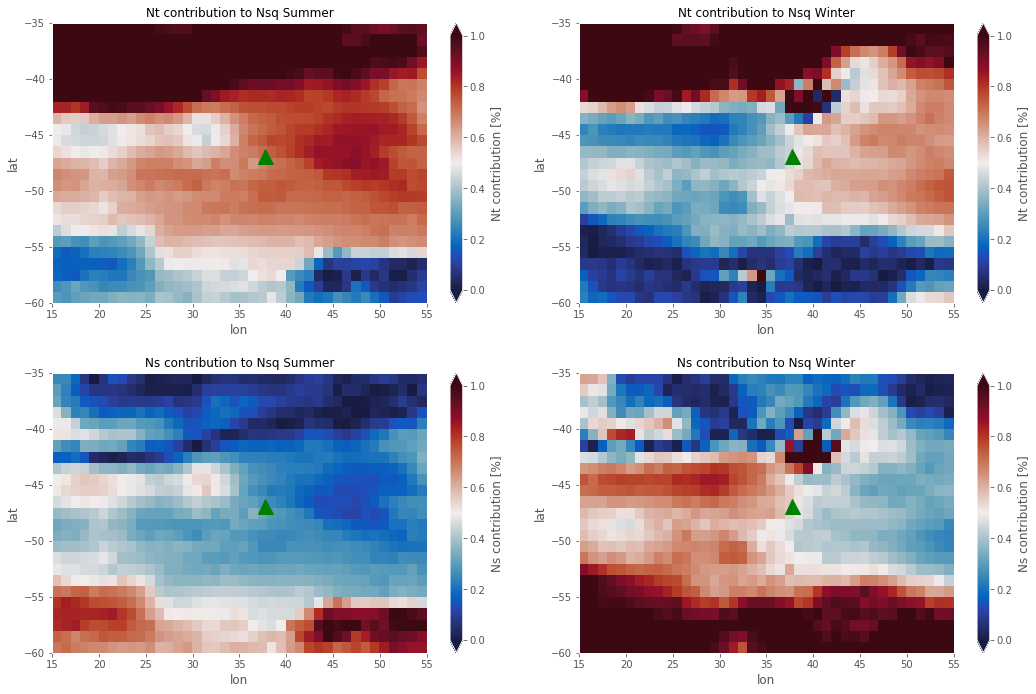

In [52]:
Summer_mld_base_N_sq = np.apply_along_axis(axis=0,arr=mld_base_Nsq[summer],func1d=np.nanmean)
Winter_mld_base_N_sq = np.apply_along_axis(axis=0,arr=mld_base_Nsq[winter],func1d=np.nanmean)

fig, ax = plt.subplots(figsize=(15, 10), ncols=2, nrows=2)

plt.subplot(2, 2, 1)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, np.abs(Summer_mld_base_Nt/Summer_mld_base_N_sq),cmap=cmo.balance,vmin=0, vmax=1)
plt.colorbar(extend='both').set_label('Nt contribution [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Nt contribution to Nsq Summer',fontsize=12)

plt.subplot(2, 2, 3)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, np.abs(Summer_mld_base_Ns/Summer_mld_base_N_sq),cmap=cmo.balance,vmin=0, vmax=1)
plt.colorbar(extend='both').set_label('Ns contribution [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Ns contribution to Nsq Summer',fontsize=12)

plt.subplot(2, 2, 2)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, np.abs(Winter_mld_base_Nt/Winter_mld_base_N_sq),cmap=cmo.balance,vmin=0, vmax=1)
plt.colorbar(extend='both').set_label('Nt contribution [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Nt contribution to Nsq Winter',fontsize=12)

plt.subplot(2, 2, 4)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, np.abs(Winter_mld_base_Ns/Winter_mld_base_N_sq),cmap=cmo.balance,vmin=0, vmax=1)
plt.colorbar(extend='both').set_label('Ns contribution [%]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Ns contribution to Nsq Winter',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/Nt_contr.png',dpi=300)


### Seasonal Nsq

## R stability ratio

In [53]:
## Stability ratio - vertical contribution of temperature to the static stability (Nsq) 
Turner_Rsubrho = gsw.Turner_Rsubrho(SA[:,:200,:,:], CT[:,:200,:,:], P[:,:200,:,:], axis=1) # P - 10.1325 dbar

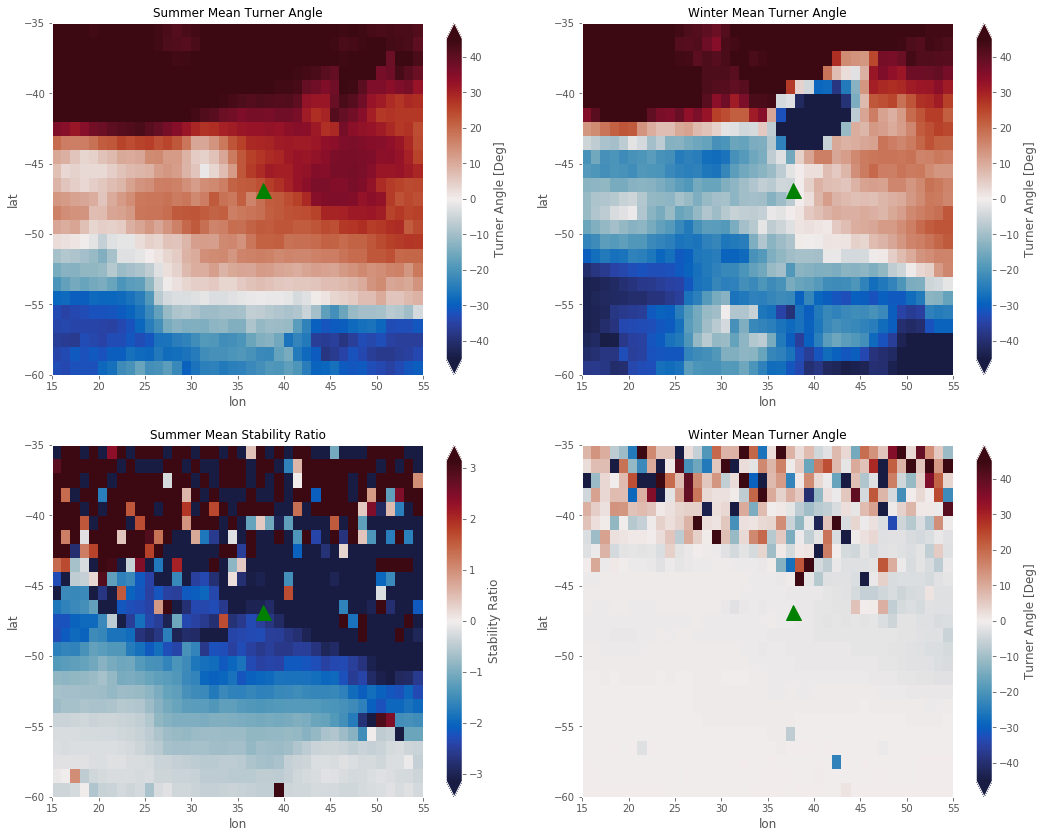

In [54]:
ntime, nlat, nlon = mld_gswda.shape
Turner_ml_base = np.empty((ntime, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            try:
                Turner_ml_base[time, lat, lon] = np.nanmean(Turner_Rsubrho[0][time,np.int(mld_gswda[time, lat, lon]):np.int(mld_gswda[time, lat, lon])+15,lat,lon])
            except:
                Turner_ml_base[time, lat, lon] = np.NaN

Rsubrho_ml_base = np.empty((ntime, nlat, nlon))

for time in tqdm_notebook(list(range(ntime))):
    for lat in range(nlat):
        for lon in range(nlon):
            try:
                Rsubrho_ml_base[time, lat, lon] = np.nanmean(Turner_Rsubrho[1][time,np.int(mld_gswda[time, lat, lon]):np.int(mld_gswda[time, lat, lon])+15,lat,lon])
            except:
                Rsubrho_ml_base[time, lat, lon] = np.NaN

Turner_summer = np.apply_along_axis(axis=0,arr=Turner_ml_base[summer],func1d=np.nanmean)
Rsubrho_summer = np.apply_along_axis(axis=0,arr=Rsubrho_ml_base[summer],func1d=np.nanmean)
Turner_winter = np.apply_along_axis(axis=0,arr=Turner_ml_base[winter],func1d=np.nanmean)
Rsubrho_winter = np.apply_along_axis(axis=0,arr=Rsubrho_ml_base[winter],func1d=np.nanmean)

fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=2)

plt.subplot(2, 2, 1)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Turner_summer, cmap=cmo.balance, vmin=-45, vmax=45)
plt.colorbar(extend='both').set_label('Turner Angle [Deg]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Summer Mean Turner Angle',fontsize=12)

plt.subplot(2, 2, 2)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Turner_winter, cmap=cmo.balance, vmin=-45, vmax=45)
plt.colorbar(extend='both').set_label('Turner Angle [Deg]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Winter Mean Turner Angle',fontsize=12)

plt.subplot(2, 2, 3)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Rsubrho_summer, cmap=cmo.balance, vmin=-pi, vmax=pi)
plt.colorbar(extend='both').set_label('Stability Ratio')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Summer Mean Stability Ratio',fontsize=12)

plt.subplot(2, 2, 4)
plt.pcolormesh(Tmld_init.lon.values, Tmld_init.lat.values, Rsubrho_winter, cmap=cmo.balance, vmin=-45, vmax=45)
plt.colorbar(extend='both').set_label('Turner Angle [Deg]')
plt.ylabel('lat')
plt.xlabel('lon')
plt.plot(37.73555555555556,-46.8886111,"^",ms=15, c='g')
plt.title('Winter Mean Turner Angle',fontsize=12)

fig.tight_layout(pad=2.0)
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Objective Analysis Data/Stability.png',dpi=300)


#Turner angles between 45° and 90° represent the “salt-finger” regime of double-diffusive convection, with the strongest activity near 90°. 
#Turner angles between -45° and -90° represent the “diffusive” regime of double-diffusive convection, with the strongest activity near −90°. 
#Turner angles between -45° and 45° represent regions where the stratification is stably stratified in both Θ and Sa. 
#Turner angles greater than 90° or less than -90° characterize a statically unstable water column in which N^2 < 0.

#stability ratio Rρ is the ratio of the vertical contribution from Conservative Temperature to that from Absolute Salinity to the static stability N^2 of the water column.